<a href="https://colab.research.google.com/github/MichelaMarini/MATH-6373-PyTorch-tutorial/blob/main/WEEK_5_TRANSFER_LEARNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
Transfer Learning is a machine learning method that reuses a
trained model designed for a particular task to accomplish a
different yet related task



We will use pre-trained networks to solved challenging problems in computer vision. Specifically, we will use networks trained on ImageNet available from torchvision.

ImageNet is a massive dataset with 1.2 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers.

Once trained, these models work well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify Fashion MNIST dataset https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html.

With torchvision.models you can download these pre-trained networks and use them in your applications.

100%|██████████| 26.4M/26.4M [00:00<00:00, 107MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.45MB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 66.5MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.5MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

class_labels {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
Image shape: torch.Size([64, 1, 224, 224])


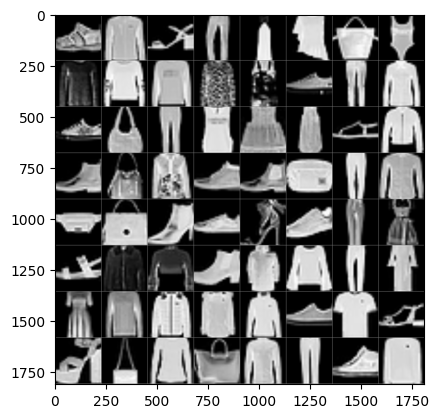

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision

from torch import nn
from torch import optim
from torchvision import datasets, transforms, models


# Define transforms for the training data and testing data
train_transforms = transforms.Compose([
   transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Download and load the MNIST Fashion dataset
train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transforms)
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

# Plotting all classes
classes = train_data.classes
class_labels = {i: classes[i] for i in range(len(classes))}
print("class_labels", class_labels)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

# Iterate through the data loader to fetch a batch of images and labels
for images, labels in trainloader:
    # show images
    print("Image shape:", images.shape)
    imshow(torchvision.utils.make_grid(images))
    break  # Break after displaying the first batch

We can load in a model such as VGG16.

In [2]:
model = models.vgg16(pretrained=True)
model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 177MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is composed of 2 fully-connected layer (classifier). This classifier was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own.

In [3]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In PyTorch, requires_grad is a Boolean flag that indicates whether gradients need to be computed with respect to a parameter during the backward pass (i.e., during gradient computation). When requires_grad is set to True, gradients are computed, and the parameter gets updated during the optimization process (e.g., using SGD, Adam). However, when it's set to False, gradients aren't computed for that parameter during the backward pass, and it remains constant during optimization.

In [5]:
# Set requires_grad=False for all parameters except those in the classifier
for param in model.parameters():
    param.requires_grad = False

# Set requires_grad=True for parameters in the classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# need to change the first convolutional layer since we have gray scale images vs rgb images from ImageNet
model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

# Modify the classifier
classifier_input_size = model.classifier[0].in_features
num_classes = len(train_data.classes)
print("num_classes", num_classes)


classifier = nn.Sequential(
    nn.Linear(classifier_input_size, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes)
)

model.classifier = classifier
print(model.classifier)

num_classes 10
Sequential(
  (0): Linear(in_features=25088, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=10, bias=True)
)


In [6]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", device)
criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device)

device cuda


VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5

# Loop over the epochs
for epoch in range(epochs):
    # Loop over the training data loader

    for inputs, labels in trainloader:
        steps += 1
        # Move inputs and labels to the appropriate device (e.g., GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass: compute predicted outputs by passing inputs to the model
        logps = model.forward(inputs)
        loss = criterion(logps, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            total = 0
            correct = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model.forward(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            # Calculate accuracy after the inner loop ends
            accuracy = correct / total

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy:.3f}")

            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 1.722.. Test loss: 1.126.. Test accuracy: 0.559
Epoch 1/1.. Train loss: 0.902.. Test loss: 0.774.. Test accuracy: 0.722
Epoch 1/1.. Train loss: 0.635.. Test loss: 0.669.. Test accuracy: 0.761
Epoch 1/1.. Train loss: 0.651.. Test loss: 0.646.. Test accuracy: 0.772
Epoch 1/1.. Train loss: 0.567.. Test loss: 0.611.. Test accuracy: 0.780
Epoch 1/1.. Train loss: 0.671.. Test loss: 0.600.. Test accuracy: 0.785
Epoch 1/1.. Train loss: 0.615.. Test loss: 0.554.. Test accuracy: 0.799
Epoch 1/1.. Train loss: 0.625.. Test loss: 0.526.. Test accuracy: 0.805
Epoch 1/1.. Train loss: 0.500.. Test loss: 0.521.. Test accuracy: 0.814
Epoch 1/1.. Train loss: 0.540.. Test loss: 0.535.. Test accuracy: 0.809
Epoch 1/1.. Train loss: 0.451.. Test loss: 0.518.. Test accuracy: 0.822
Epoch 1/1.. Train loss: 0.554.. Test loss: 0.480.. Test accuracy: 0.826
Epoch 1/1.. Train loss: 0.534.. Test loss: 0.499.. Test accuracy: 0.825
Epoch 1/1.. Train loss: 0.434.. Test loss: 0.562.. Test accuracy

**Exercise**: Train a pretrained DenseNet model to classify the Fashion MNIST dataset. Ensure that only the classifier is trained while keeping the feature extraction layers frozen. Additionally, implement early stopping if the test accuracy does not improve after every 5 (batches) training steps.